In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from datetime import datetime
import math
import os


In [62]:
total_sales_df = pd.read_csv("data/total_sales_df.csv")
total_vehicle_sales_df = pd.read_csv("data/total_vehicle_sales_df.csv")

In [63]:
y = total_sales_df['total sales']
x = total_sales_df['timestamp']

In [64]:
#some confidence interval
ci = 3 * np.std(y) # 3 sigma

In [65]:
print(np.std(y))

9034.390521224994


[0.00016392]
[74691.65653685]


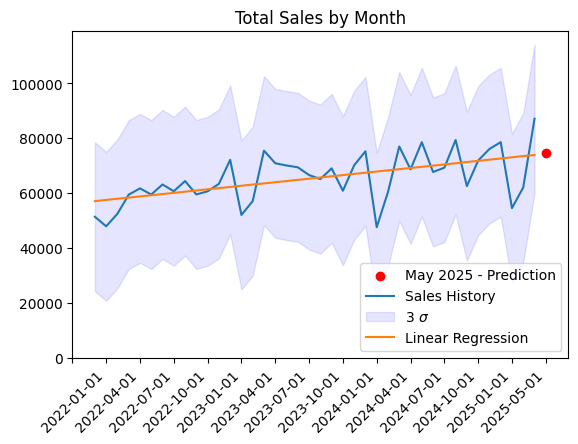

In [66]:
fig, ax = plt.subplots()


# train model 
x_dt = x.apply(lambda q: datetime.strptime(q, "%Y-%m-%d")) 
x_np = x_dt.apply(lambda q: q.timestamp()).to_numpy().reshape(-1, 1)
reg = LinearRegression().fit(x_np, y)

# evaluate model
reg.score(x_np, y)

# y=ax+b
a = reg.coef_
b = reg.intercept_
y_reg = a * x_np + b
print(a)

# make prediction
may_1st_2025 = datetime(2025, 5, 1)
x_pred = np.array(may_1st_2025.timestamp()).reshape(1, -1)
y_pred = reg.predict(x_pred)
print(y_pred)
    
# plot
pred_date_str = may_1st_2025.strftime("%Y-%m-%d")
plt.scatter(pred_date_str, y_pred,color='red', label='May 2025 - Prediction')
ax.plot(x, y, label='Sales History')
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1, label=r'3 $\sigma$')
plt.plot(x, y_reg.reshape(-1, 1), label='Linear Regression')
ax.set_title('Total Sales by Month')
ax.set_ylim(0)
ax.figure.autofmt_xdate(rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax.invert_xaxis()
ax.legend()
save_path = os.path.join('images', 'Total Sales by Month.png')
plt.savefig(save_path)

In [67]:
# convert to long (tidy) form
dfm = total_vehicle_sales_df.melt('timestamp', var_name='Vehicles', value_name='Unit Sold')


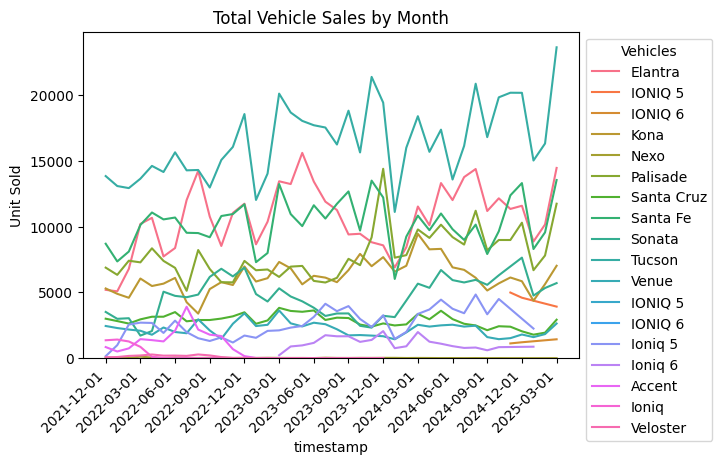

In [68]:
ax = sns.lineplot(data=dfm, x="timestamp", y="Unit Sold", hue="Vehicles")
ax.set_title('Total Vehicle Sales by Month')
ax.set_ylim(0)
ax.figure.autofmt_xdate(rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax.invert_xaxis()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
save_path = os.path.join('images', 'Total Vehicle Sales by Month.png')
plt.savefig(save_path)

### 'Vehicle' Sales Prediction

In [69]:
unique_strings = dfm['Vehicles'].unique().tolist()

In [70]:
unique_strings

['Elantra',
 'IONIQ 5',
 'IONIQ 6',
 'Kona',
 'Nexo',
 'Palisade',
 'Santa Cruz',
 'Santa Fe',
 'Sonata',
 'Tucson',
 'Venue',
 'IONIQ\xa05',
 'IONIQ\xa06',
 'Ioniq 5',
 'Ioniq 6',
 'Accent',
 'Ioniq',
 'Veloster']

In [71]:
def remove_nan_and_corresponding(x, y):
    # Create a mask where y is not NaN
    mask = ~np.isnan(y)
    
    # Use the mask to filter both x and y
    x_cleaned = x[mask]
    y_cleaned = y[mask]

    if mask.ndim == 2:
        mask = mask.flatten()

    return x_cleaned, y_cleaned, mask

In [72]:
def create_prediction_plots(dfm, curr_vehicle_name):
    # create dataset
    vehicle_df = dfm.loc[dfm['Vehicles']==curr_vehicle_name]
    x_str = vehicle_df['timestamp']
    vehicle_df['timestamp'] = vehicle_df['timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d")) 
    x = vehicle_df['timestamp'].apply(lambda x: x.timestamp()).to_numpy()
    y = vehicle_df['Unit Sold'].to_numpy()
    cleaned = False
    if np.isnan(np.sum(y)):
        x_clean, y_clean, mask = remove_nan_and_corresponding(x, y)
        x_str_clean = x_str[mask]
        cleaned = True
    else:
        x_clean = x
        y_clean = y
        x_str_clean = x_str

    x_clean = x_clean.reshape(-1, 1)
    y_clean = y_clean.reshape(-1, 1)


    startTime = datetime.fromtimestamp(x_clean[0][0]).strftime('%Y-%m-%d')


    # train model 
    reg = LinearRegression().fit(x_clean, y_clean)

    # evaluate model
    reg.score(x_clean, y_clean)

    # y=ax+b
    a = reg.coef_
    b = reg.intercept_
    y_reg = a * x + b

    # make prediction
    may_1st_2025 = datetime(2025, 5, 1)
    x_pred = np.array(may_1st_2025.timestamp()).reshape(1, -1)
    y_pred = reg.predict(x_pred)
        
    # plot

    fig, ax = plt.subplots()
    pred_date_str = may_1st_2025.strftime("%Y-%m-%d")
    plt.scatter(pred_date_str, y_pred, color='red', label='May 25 - Prediction')
    plt.plot(x_str, y, label='Historical Data')
    plt.plot(x_str, y_reg.reshape(-1, 1), label='Linear Regression')
    plt.gca().invert_xaxis()

    if cleaned:
        moveAmount = len(mask) - mask.sum()
        ax.set_xlim(np.array([-moveAmount + 3, 0])+ax.get_xlim())
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    ax.tick_params(axis='x', rotation=45)
    plt.title(f"{curr_vehicle_name} Sales Forecast", fontsize=16, fontweight='bold', color='darkblue', loc='center', pad=10)
    ax.legend()
    plt.xlabel("Timestamp")
    plt.ylabel("Unit Sold")
    plt.savefig('images\\'+ curr_vehicle_name + '.png', format = 'png')
    
    return y_pred[0]
        

C:\Users\LR\AppData\Local\Temp\ipykernel_18468\2717405775.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehicle_df['timestamp'] = vehicle_df['timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
C:\Users\LR\AppData\Local\Temp\ipykernel_18468\2717405775.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehicle_df['timestamp'] = vehicle_df['timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
C:\Users\LR\AppData\Local\Temp\ipykernel_18468\2717405775.py:5: SettingWithCopyWarning: 
A v

May Sales Prediction by Vehicle
        Elantra      IONIQ 5      IONIQ 6         Kona      Nexo     Palisade  \
0  12434.713649  3372.901603  1595.348397  6997.348938 -4.161232  9755.242229   

    Santa Cruz      Santa Fe       Sonata        Tucson       Venue  IONIQ 5  \
0  2438.062925  10903.510109  5913.125186  19384.618286  1965.27664   2442.0   

   IONIQ 6      Ioniq 5     Ioniq 6      Accent       Ioniq    Veloster  
0   1012.0  4185.056504  905.566657 -1624.86542 -964.663631 -208.354754  


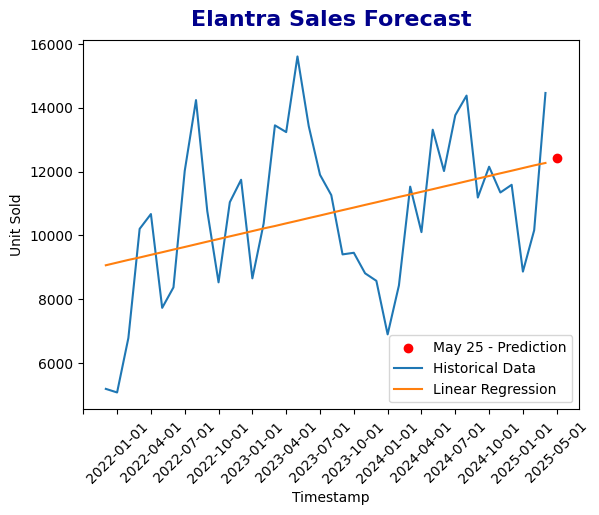

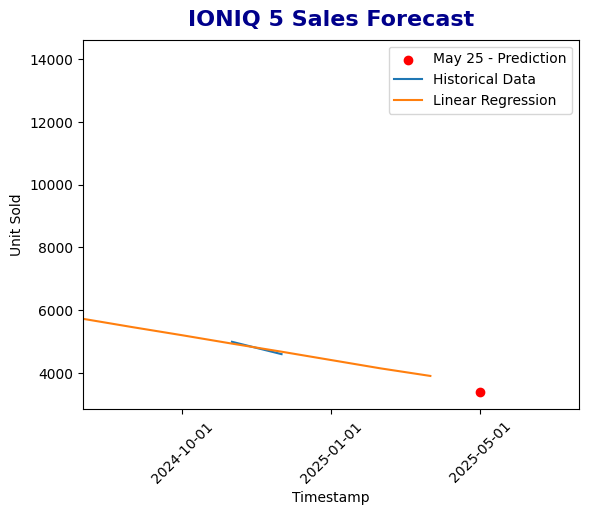

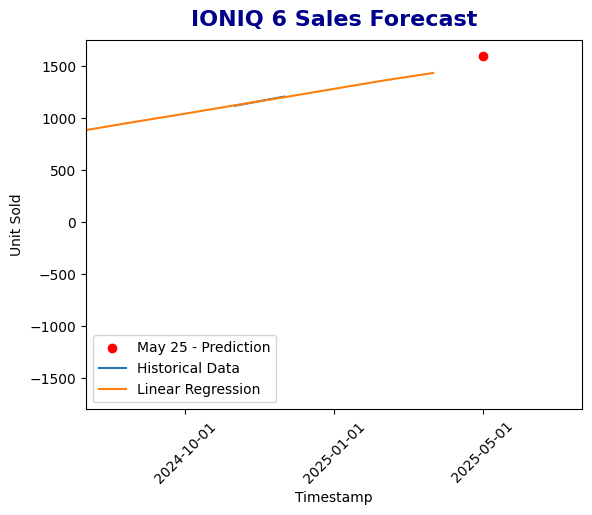

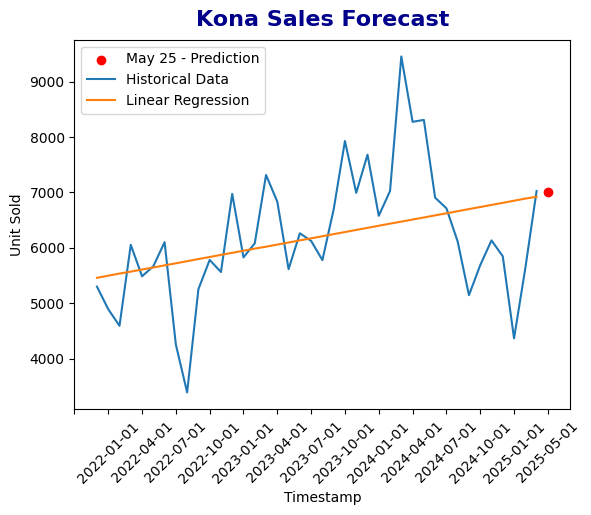

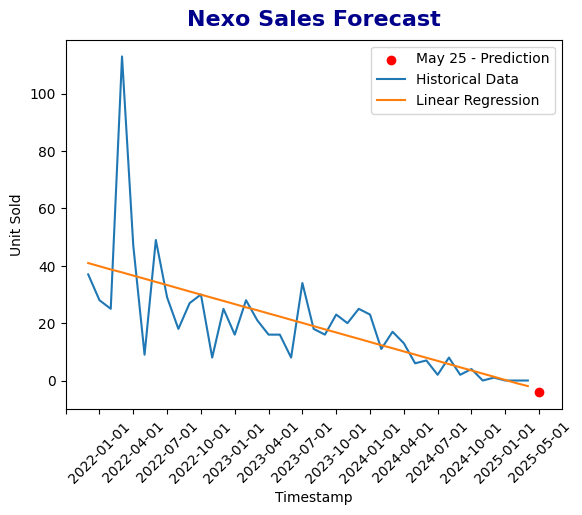

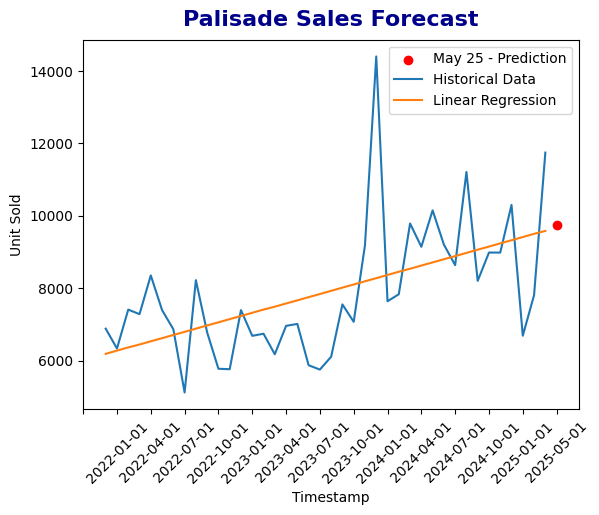

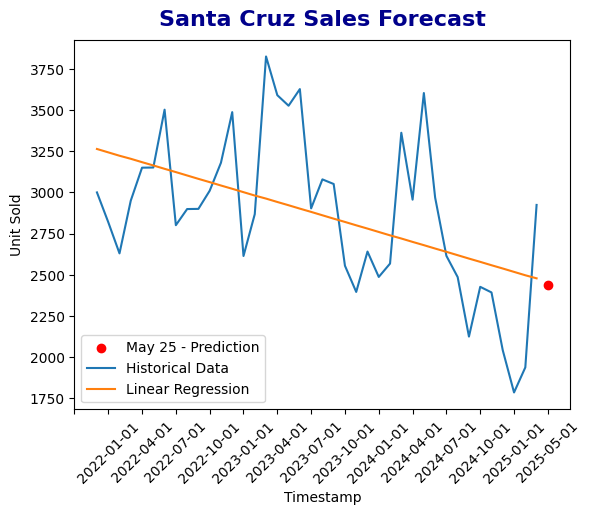

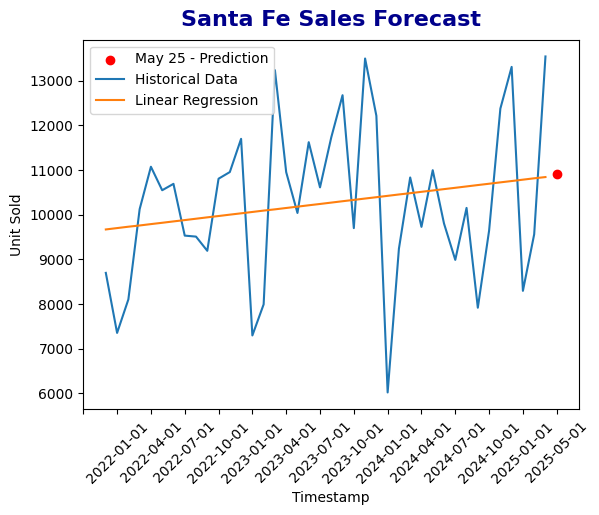

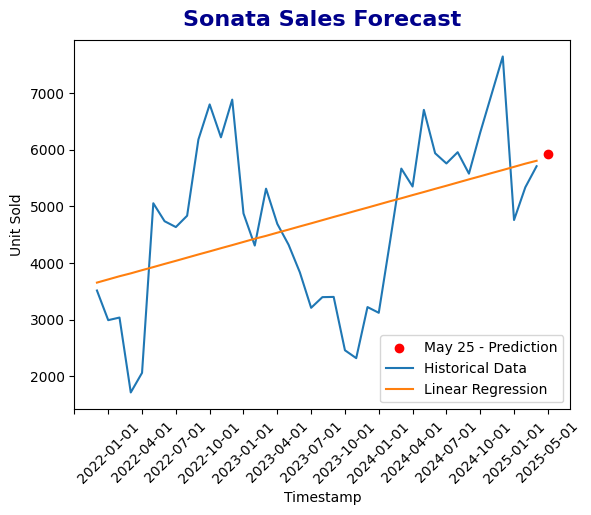

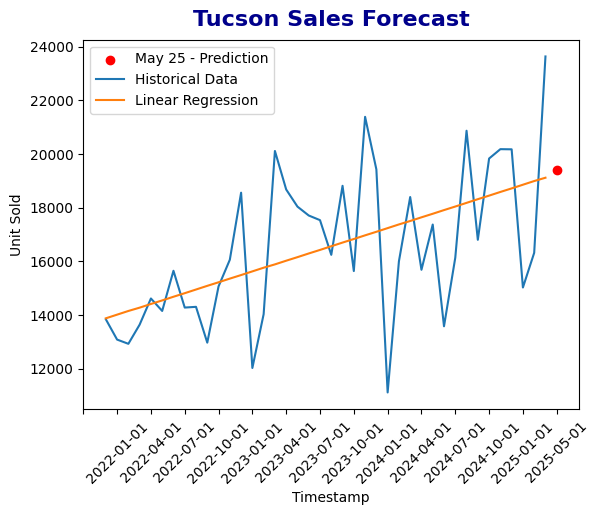

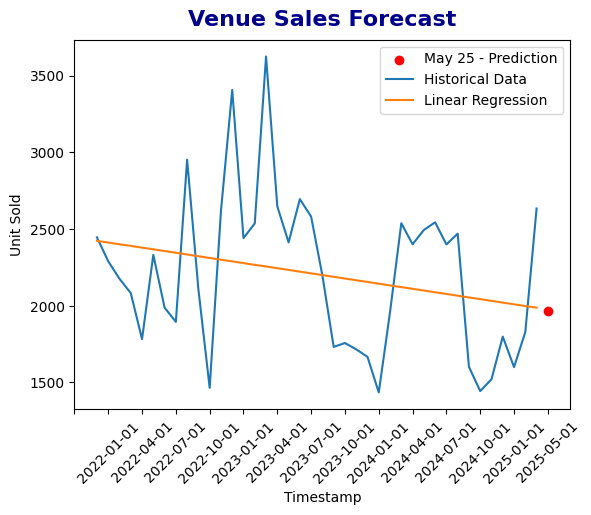

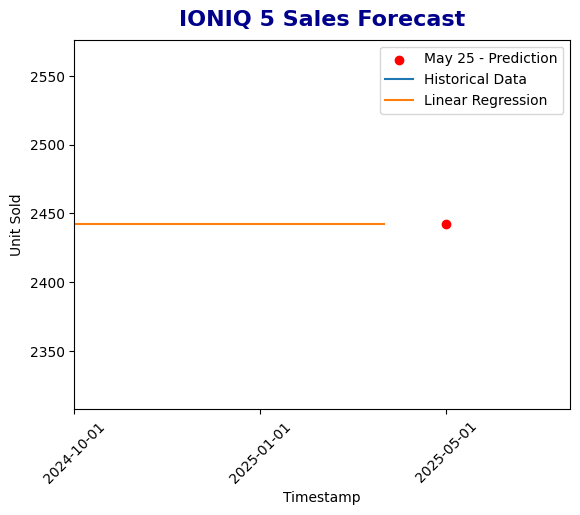

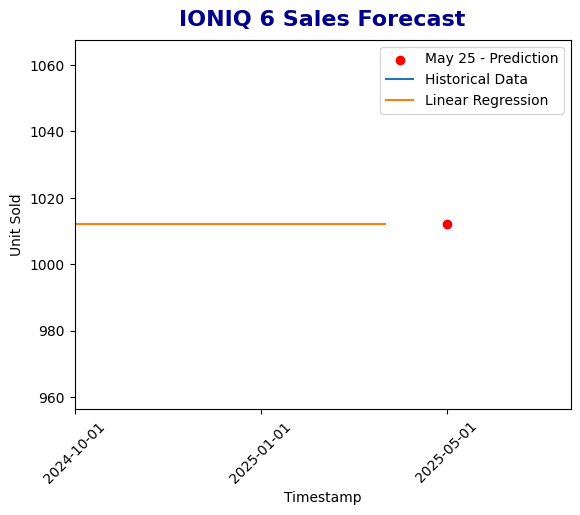

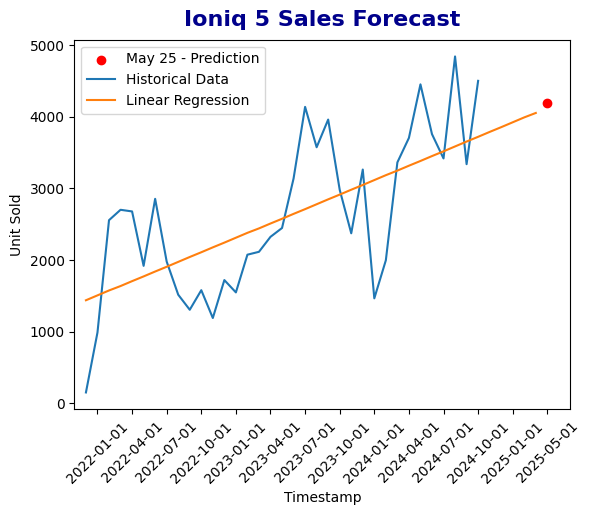

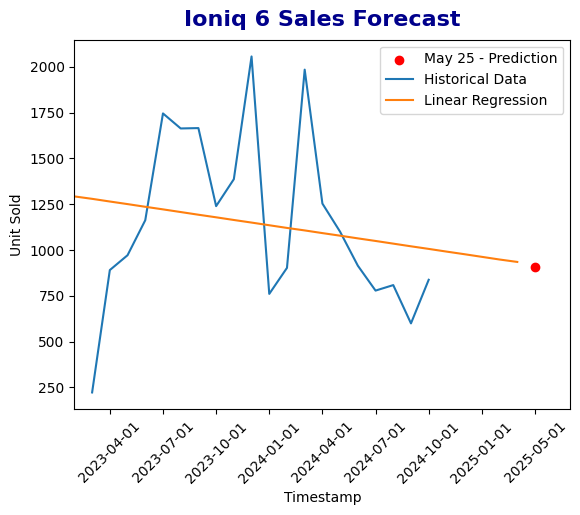

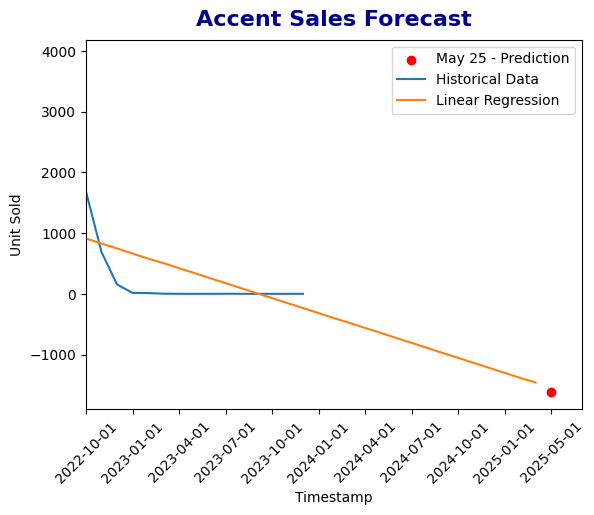

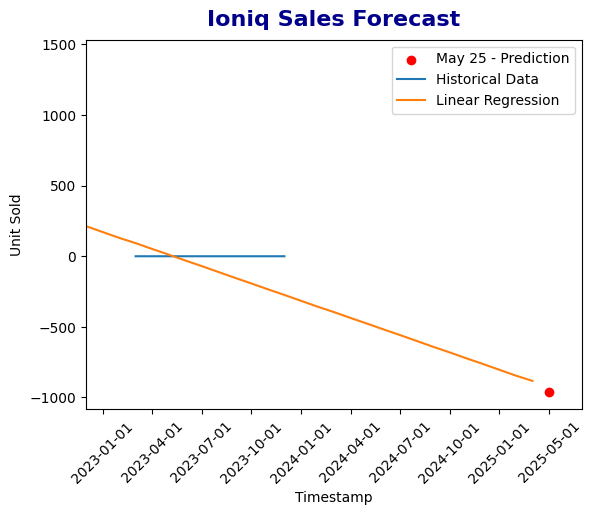

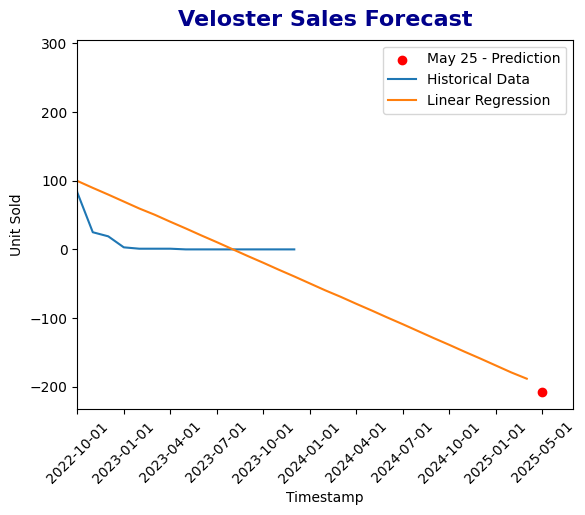

In [73]:
pred = pd.DataFrame()
for i in range(len(unique_strings)):
    pred[unique_strings[i]] = create_prediction_plots(dfm, unique_strings[i])
print("May Sales Prediction by Vehicle")
print(pred)